In [ ]:
# ============================================================
# Phase 1: Imports & Environment Setup
# ============================================================
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use("seaborn-v0_8")

# -----------------------------
# MOUNT GOOGLE DRIVE HERE
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# Setup directories
# -----------------------------
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
EMB_DIR = BASE_DIR / "data" / "embeddings"
DATA_DIR.mkdir(exist_ok=True, parents=True)
EMB_DIR.mkdir(exist_ok=True, parents=True)

print("Working directory:", BASE_DIR)


# ============================================================
# Phase 2: Load Dataset from Google Drive
# ============================================================
gdrive_path = Path("/content/drive/MyDrive/Datasets/resume_dataset.csv")

if gdrive_path.exists():
    raw_path = gdrive_path
    print("Using Google Drive dataset at:", raw_path)
else:
    raise FileNotFoundError(
        f"Could not find dataset.\n"
        f"- {gdrive_path}\n"
        f"Please check your Google Drive path."
    )

# Load full dataset, then (optionally) down-sample so we do not process everything
df_full = pd.read_csv(raw_path)
print("Full loaded shape:", df_full.shape)

MAX_ROWS_FOR_EXPERIMENT = 50000  # change this number to control sample size

if len(df_full) > MAX_ROWS_FOR_EXPERIMENT:
    df = df_full.sample(n=MAX_ROWS_FOR_EXPERIMENT, random_state=42).reset_index(drop=True)
    print(
        f"Using random sample of {len(df)} rows out of {len(df_full)} total "
        f"for faster experimentation."
    )
else:
    df = df_full

print("Working dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
display(df.head(3))

print(
    "Unique resume IDs:",
    df["resume_id"].nunique() if "resume_id" in df.columns else "no resume_id column",
)
print(
    "Unique job IDs:",
    df["job_id"].nunique() if "job_id" in df.columns else "no job_id column",
)
if "similarity_score" in df.columns:
    print("\nSimilarity score stats:\n", df["similarity_score"].describe())


Mounted at /content/drive
Working directory: /content
Using Google Drive dataset at: /content/drive/MyDrive/Datasets/resume_dataset.csv
Full loaded shape: (9544, 35)
Working dataset shape: (9544, 35)

Columns: ['address', 'career_objective', 'skills', 'educational_institution_name', 'degree_names', 'passing_years', 'educational_results', 'result_types', 'major_field_of_studies', 'professional_company_names', 'company_urls', 'start_dates', 'end_dates', 'related_skils_in_job', 'positions', 'locations', 'responsibilities', 'extra_curricular_activity_types', 'extra_curricular_organization_names', 'extra_curricular_organization_links', 'role_positions', 'languages', 'proficiency_levels', 'certification_providers', 'certification_skills', 'online_links', 'issue_dates', 'expiry_dates', 'job_position_name', 'educationaL_requirements', 'experiencere_requirement', 'age_requirement', 'responsibilities.1', 'skills_required', 'matched_score']

Missing values per column:
 address                    

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667


Unique resume IDs: no resume_id column
Unique job IDs: no job_id column


In [ ]:
# ============================================================
# Phase 3: Text Cleaning Utilities
# ============================================================
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.replace("\r", " ").replace("\n", " ").replace("\t", " ")
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove non-ASCII
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s\.,;:!\?\(\)\-\/@#&%]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Try common column names first; if none, fall back to “longest text” columns.
text_cols = []
for col in ["resume_text", "job_description", "resume", "jobdesc", "resume_content"]:
    if col in df.columns:
        text_cols.append(col)

if not text_cols:
    lengths = {c: df[c].astype(str).map(len).median() for c in df.columns}
    sorted_cols = sorted(lengths.items(), key=lambda x: x[1], reverse=True)
    text_cols = [sorted_cols[0][0]]
    if len(sorted_cols) > 1:
        text_cols.append(sorted_cols[1][0])
    print("No standard text column names found. Using fallback columns:", text_cols)
else:
    print("Using text columns:", text_cols)

for c in text_cols:
    cleaned_name = c + "_clean"
    df[cleaned_name] = df[c].apply(clean_text)
    print(f"Created cleaned column: {cleaned_name}")

No standard text column names found. Using fallback columns: ['skills', 'responsibilities']
Created cleaned column: skills_clean
Created cleaned column: responsibilities_clean


Rows kept after dropping empties (both fields needed): 9432 (dropped 112)
Dropped duplicates: 28


/tmp/ipython-input-218179194.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=dup_subset, inplace=True)


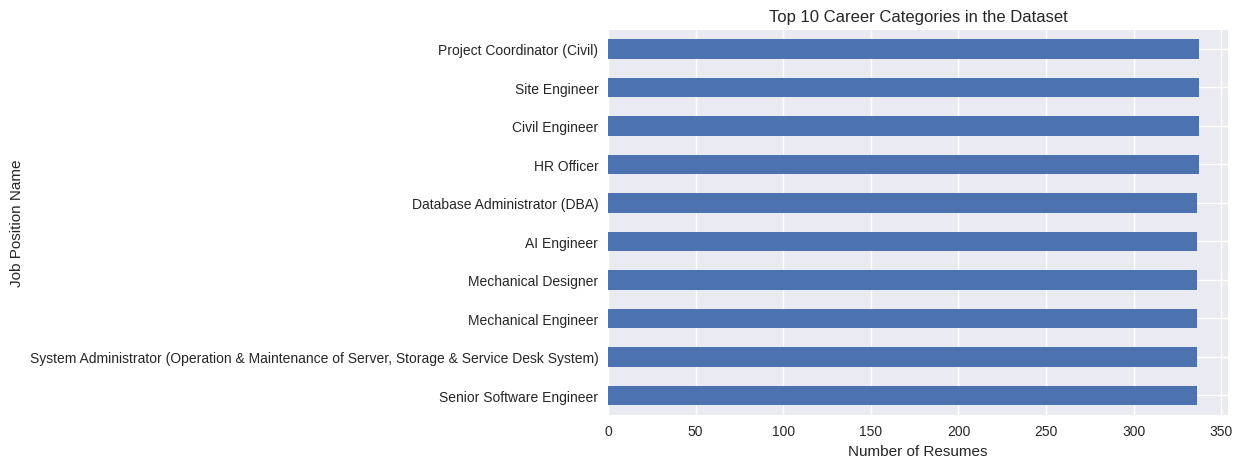

In [ ]:
# ============================================================
# Phase 4: Drop Empty / Duplicate Rows
# ============================================================
resume_col_clean = text_cols[0] + "_clean"
job_col_clean = text_cols[1] + "_clean" if len(text_cols) > 1 else None

if job_col_clean:
    before = df.shape[0]
    df = df[~((df[resume_col_clean] == "") | (df[job_col_clean] == ""))]
    after = df.shape[0]
    print(
        f"Rows kept after dropping empties (both fields needed): {after} (dropped {before - after})"
    )
else:
    before = df.shape[0]
    df = df[df[resume_col_clean] != ""]
    after = df.shape[0]
    print(
        f"Rows kept after dropping empty resumes: {after} (dropped {before - after})"
    )

dup_subset = [resume_col_clean] + ([job_col_clean] if job_col_clean else [])
before = df.shape[0]
df.drop_duplicates(subset=dup_subset, inplace=True)
after = df.shape[0]
print(f"Dropped duplicates: {before - after}")

df.reset_index(drop=True, inplace=True)

# ============================================================
# Phase 5: Simple EDA (Top Job Categories)
# ============================================================
if "job_position_name" in df.columns:
    top_jobs = df["job_position_name"].value_counts().head(10)
    plt.figure(figsize=(8, 5))
    top_jobs.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Top 10 Career Categories in the Dataset")
    plt.xlabel("Number of Resumes")
    plt.ylabel("Job Position Name")
    plt.show()
else:
    print("Column 'job_position_name' not found; skipping bar chart.")

In [ ]:
# ============================================================
# Phase 6: Save Cleaned Dataset
# ============================================================
# Choose ID columns if present
keep = []

for candidate in ["resume_id", "job_id", "candidate_id", "applicant_id"]:
    if candidate in df.columns:
        keep.append(candidate)

# Always keep cleaned text columns
keep.append(resume_col_clean)
if job_col_clean:
    keep.append(job_col_clean)

if "similarity_score" in df.columns:
    keep.append("similarity_score")

if not keep:
    keep = df.columns.tolist()
else:
    keep = list(dict.fromkeys(keep))  # unique, preserve order

clean_path = DATA_DIR / "clean_resume_data.csv"
df[keep].to_csv(clean_path, index=False)
print("Saved cleaned data to:", clean_path)

Saved cleaned data to: /content/data/clean_resume_data.csv


In [ ]:
# ============================================================
# Phase 7: Load Cleaned Data for Embedding & choose columns
# ============================================================
if clean_path.exists():
    df_cleaned = pd.read_csv(clean_path)
    print("Loaded cleaned dataset from:", clean_path)
else:
    raise FileNotFoundError(f"Cleaned dataset not found at {clean_path}")

display(df_cleaned.head(3))

# Prefer cleaned columns (ending with _clean), otherwise fall back to raw
clean_cols = [c for c in df_cleaned.columns if c.endswith("_clean")]

if len(clean_cols) >= 2:
    resume_col_for_emb = clean_cols[0]
    job_col_for_emb = clean_cols[1]
elif len(clean_cols) == 1:
    resume_col_for_emb = clean_cols[0]
    job_col_for_emb = None
else:
    text_cols_emb = []
    for col in ["resume_text", "job_description", "resume", "jobdesc", "resume_content"]:
        if col in df_cleaned.columns:
            text_cols_emb.append(col)
    if not text_cols_emb:
        raise ValueError("No suitable text columns found for embedding in cleaned dataset.")
    resume_col_for_emb = text_cols_emb[0]
    job_col_for_emb = text_cols_emb[1] if len(text_cols_emb) > 1 else None

print("Embedding resume column:", resume_col_for_emb)
print("Embedding job column:", job_col_for_emb)

Loaded cleaned dataset from: /content/data/clean_resume_data.csv


,skills_clean,responsibilities_clean
0,"big data , hadoop , hive , python , mapreduce ...",technical support troubleshooting collaboratio...
1,"data analysis , data analytics , business anal...",machine learning leadership cross-functional c...
2,"software development , machine learning , deep...","trade marketing executive brand visibility, sa..."


Embedding resume column: skills_clean
Embedding job column: responsibilities_clean


In [ ]:
# ============================================================
# Phase 8: Load Embedding Model and Generate Embeddings
# ============================================================

# Load model directly from Hugging Face
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

print("Loaded embedding model from Hugging Face.")

# Build lists from the chosen columns
resume_list = df_cleaned[resume_col_for_emb].astype(str).tolist()

if job_col_for_emb is not None:
    jd_list = df_cleaned[job_col_for_emb].astype(str).tolist()
else:
    jd_list = None

# Generate embeddings
resume_embeddings = model.encode(resume_list, batch_size=32, show_progress_bar=True)
print("Resume embeddings shape:", resume_embeddings.shape)

if jd_list is not None:
    jd_embeddings = model.encode(jd_list, batch_size=32, show_progress_bar=True)
    print("JD embeddings shape:", jd_embeddings.shape)
else:
    jd_embeddings = None
    print("No job description column selected for embedding; only resume embeddings were created.")

print("Embedding generation complete.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded embedding model from Hugging Face.


Batches:   0%|          | 0/294 [00:00<?, ?it/s]

Resume embeddings shape: (9404, 384)


Batches:   0%|          | 0/294 [00:00<?, ?it/s]

In [ ]:
# ============================================================
# Phase 9: Save Embeddings
# ============================================================
EMB_DIR.mkdir(exist_ok=True, parents=True)

resume_emb_path = EMB_DIR / "resume_embeddings.npy"
np.save(resume_emb_path, resume_embeddings)
print("Saved resume embeddings to:", resume_emb_path)

if jd_embeddings is not None:
    jd_emb_path = EMB_DIR / "jd_embeddings.npy"
    np.save(jd_emb_path, jd_embeddings)
    print("Saved job description embeddings to:", jd_emb_path)
else:
    print("No job description embeddings to save.")

In [ ]:
# ============================================================
# Phase 10: Example Similarity Query
# ============================================================
if jd_embeddings is not None:
    idx = 0  # index of resume to compare
    resume_vec = resume_embeddings[idx].reshape(1, -1)
    similarities = cosine_similarity(resume_vec, jd_embeddings)[0]

    top_matches = np.argsort(similarities)[::-1][:5]

    print(f"Top matching job descriptions for Resume {idx}:")
    for i in top_matches:
        print(f"JD {i} — similarity: {similarities[i]:.4f}")
else:
    print("JD embeddings not available; skipping similarity example.")

Top matching job descriptions for Resume 0:
JD 2785 — similarity: 0.4236
JD 4425 — similarity: 0.4236
JD 5820 — similarity: 0.4236
JD 5829 — similarity: 0.4236
JD 8220 — similarity: 0.4236


Similarity score stats:
 count    9404.000000
mean        0.220640
std         0.103319
min        -0.145328
25%         0.149396
50%         0.217530
75%         0.290165
max         0.743021
Name: similarity_score, dtype: float64
Saved ranking CSV to: /kaggle/working/data/resume_job_rankings.csv
Ranking preview (top 5 rows):


,candidate_id,job_id,rank
0,1,1,1
1,2,2,2
2,3,3,3
3,4,4,4
4,5,5,5


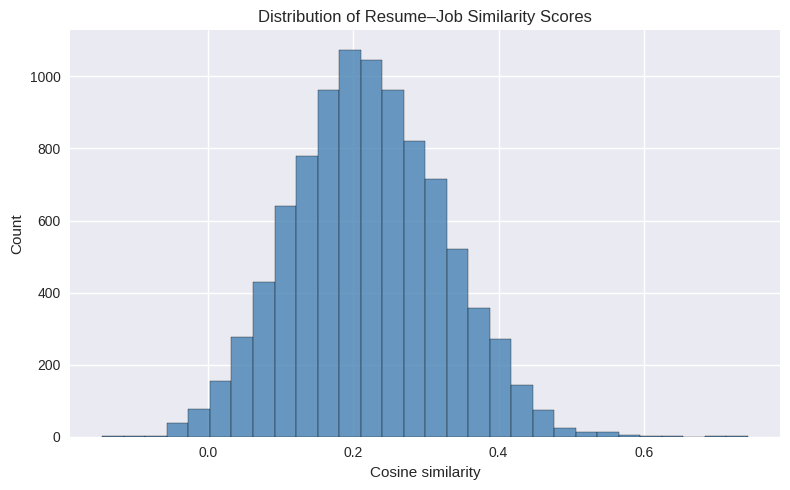

In [ ]:
# ============================================================
# Phase 11: Ranking Algorithm (Kshitiz — Ranking Lead)
# ============================================================
"""
Compute similarity between each resume and its corresponding job description,
rank by highest score, and save a ranking CSV.

Assumes the following are already defined from previous phases:
- df_cleaned: cleaned DataFrame used for embeddings
- resume_embeddings: NumPy array of resume embeddings (N x D)
- jd_embeddings: NumPy array of job-description embeddings (N x D) or None
- DATA_DIR: base data directory (Path)
"""

if jd_embeddings is None:
    raise ValueError(
        "JD embeddings are not available. Make sure Phase 8 ran with a valid "
        "job description column before running the ranking phase."
    )

# 1) Compute pairwise cosine similarity for each (resume_i, jd_i) pair
#    Using a loop for clarity and to avoid building a large full similarity matrix.
from sklearn.metrics.pairwise import cosine_similarity

pairwise_similarities = [
    cosine_similarity(
        resume_embeddings[i : i + 1],
        jd_embeddings[i : i + 1],
    )[0, 0]
    for i in range(len(resume_embeddings))
]

# Attach similarity scores back to the cleaned DataFrame
ranked_df = df_cleaned.copy()
ranked_df["similarity_score"] = pairwise_similarities

print("Similarity score stats:\n", ranked_df["similarity_score"].describe())

# 2) Create a rank column (1 = highest similarity)
ranked_df = ranked_df.sort_values(by="similarity_score", ascending=False).reset_index(drop=True)
ranked_df["rank"] = ranked_df.index + 1

# 3) Ensure we have candidate_id and job_id columns in a dynamic way
# Try to reuse existing identifiers when present; otherwise, create new ones.

# Candidate identifier
if "candidate_id" in ranked_df.columns:
    candidate_col = "candidate_id"
elif "applicant_id" in ranked_df.columns:
    candidate_col = "applicant_id"
elif "resume_id" in ranked_df.columns:
    candidate_col = "resume_id"
else:
    candidate_col = "candidate_id"
    ranked_df[candidate_col] = range(1, len(ranked_df) + 1)

# Job identifier
if "job_id" in ranked_df.columns:
    job_col = "job_id"
else:
    # Fall back to a reasonable proxy if no explicit job_id exists
    if "job_position_name" in ranked_df.columns:
        ranked_df["job_id"] = ranked_df["job_position_name"].astype(str)
    else:
        ranked_df["job_id"] = range(1, len(ranked_df) + 1)
    job_col = "job_id"

# 4) Build final ranking output with required schema
#    Always expose columns as: candidate_id, job_id, rank
output_ranking = ranked_df[[candidate_col, job_col, "rank"]].copy()
output_ranking = output_ranking.rename(
    columns={candidate_col: "candidate_id", job_col: "job_id"}
)

ranking_path = DATA_DIR / "resume_job_rankings.csv"
output_ranking.to_csv(ranking_path, index=False)

print("Saved ranking CSV to:", ranking_path)
print("Ranking preview (top 5 rows):")
display(output_ranking.head())

# 5) Plot distribution of similarity scores
plt.figure(figsize=(8, 5))
plt.hist(ranked_df["similarity_score"], bins=30, color="steelblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Resume–Job Similarity Scores")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


PHASE 6: BIAS DETECTION & FAIRNESS EVALUATION

Loaded 233 bias indicators across all categories

Detecting bias in ranked resume texts...

Bias Detection Summary (Before Neutralization):
------------------------------------------------------------
Bias Categories Being Detected:
  1. Prestige Institutions (Harvard, MIT, Ivy League, etc.)
  2. Prestige Companies (Google, Microsoft, FAANG, etc.)
  3. Prestige Locations (Silicon Valley, NYC, etc.)
  4. Gender Indicators (pronouns, titles, explicit gender terms)
  5. Protected Characteristics (veteran, ethnicity, disability)

Resumes with prestige institutions: 84 (0.89%)
Resumes with prestige companies: 2996 (31.86%)
Resumes with prestige locations: 436 (4.64%)
Resumes with gender/protected characteristics: 996 (10.59%)
Average total bias score: 0.68
Max bias score: 5.50

Creating bias-neutralized text...

Detecting bias in neutralized texts...

Bias Detection Summary (After Neutralization):
-----------------------------------------------

Batches:   0%|          | 0/294 [00:00<?, ?it/s]

Neutralized resume embeddings shape: (9404, 384)

Similarity Score Comparison:
------------------------------------------------------------
Original mean similarity: 0.2206
Neutralized mean similarity: 0.2215
Difference: 0.0009

Calculating Fairness Metrics...

1. Bias Score Reduction: 0.44%
2. Rank Stability (Spearman correlation): 0.2719
   (1.0 = perfect stability, 0.0 = no correlation)

3. Fairness Index:
   Before neutralization: 0.7645
   After neutralization: 0.7660
   Improvement: 0.15 percentage points

GENERATING BIAS REPORT

Bias report saved to: /kaggle/working/data/bias_fairness_report.txt

Generating visualizations...
Visualization saved to: /kaggle/working/data/bias_fairness_analysis.png


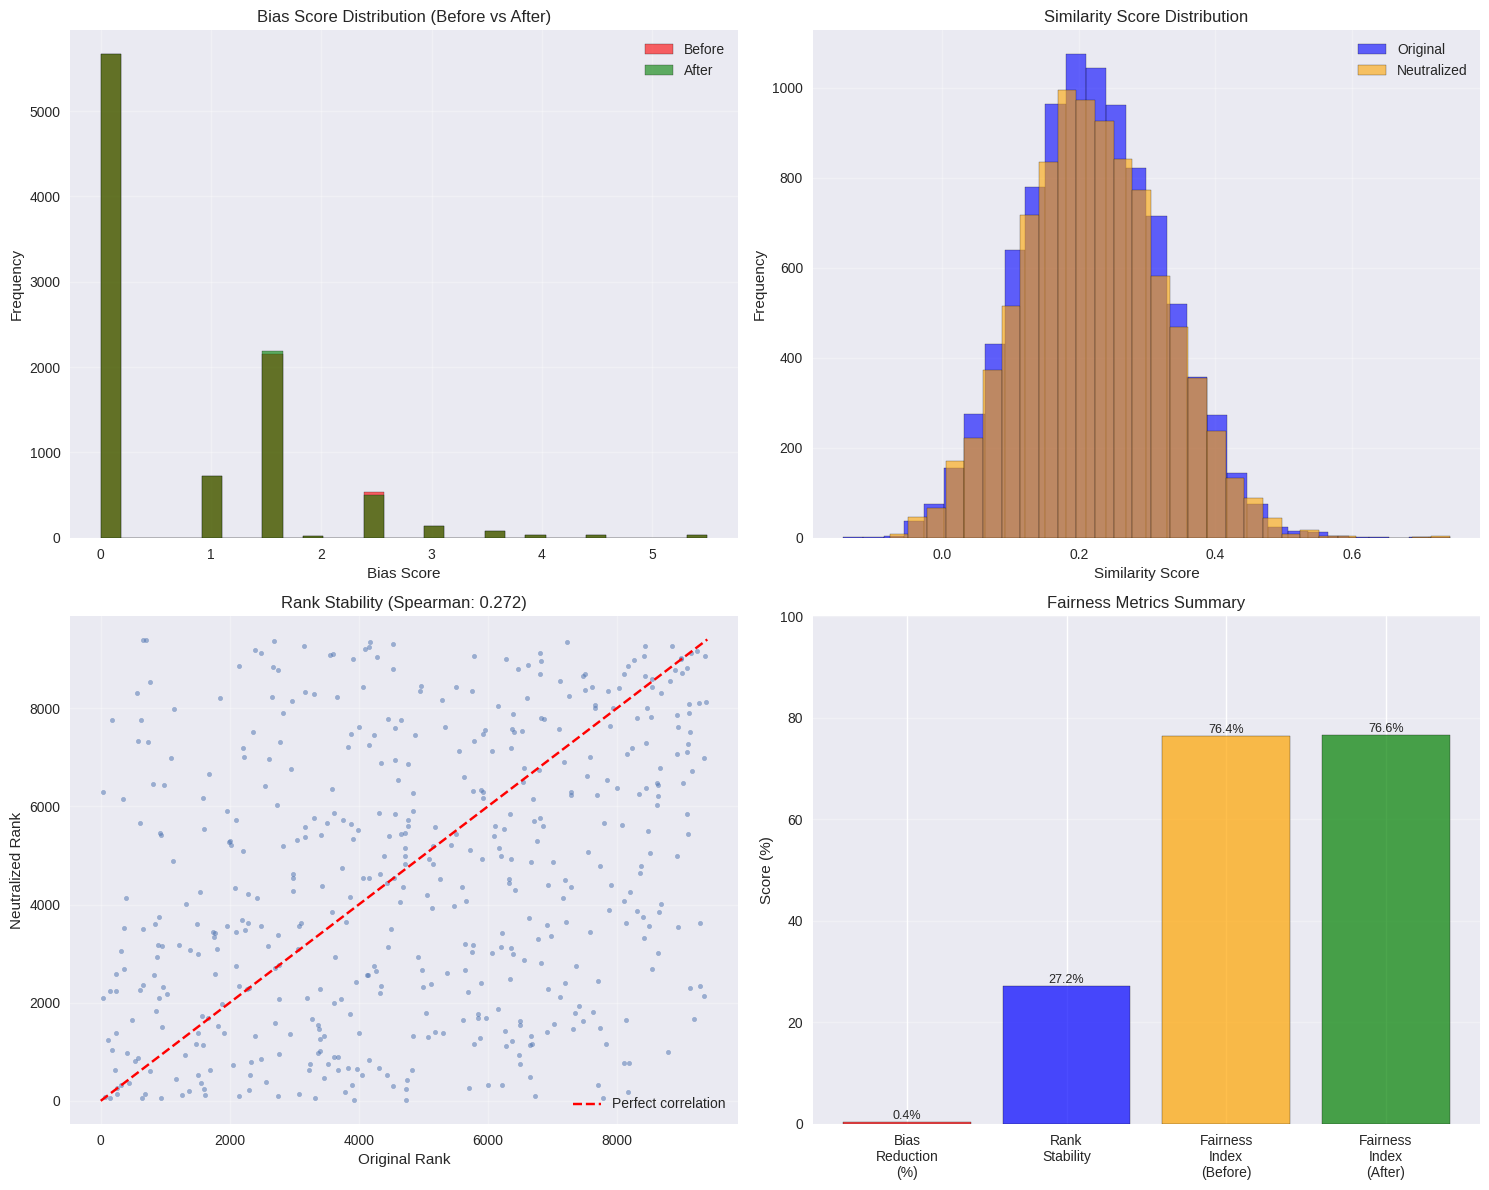


Comparison results saved to: /kaggle/working/data/bias_neutralized_rankings.csv

Summary:
  - Bias reduction: 0.44%
  - Rank stability: 0.2719
  - Fairness improvement: 0.15 pp

Files generated:
  - /kaggle/working/data/bias_fairness_report.txt
  - /kaggle/working/data/bias_fairness_analysis.png
  - /kaggle/working/data/bias_neutralized_rankings.csv


In [ ]:
# ============================================================
# Phase 6: Bias Detection & Fairness Evaluation (Sadikshya)
# ============================================================
"""
Goal: Measure fairness and reduce bias in resume ranking.

IMPORTANT: This phase runs AFTER Phase 11 (Ranking Algorithm).
It uses ranked_df which contains similarity_score and rank from Phase 11.

Steps:
1. Detect bias indicators (gender words, prestige terms) in ranked resumes
2. Apply fairness adjustments (lower weights to biased terms)
3. Recalculate similarity with bias-neutralized text
4. Compare original ranking vs neutralized ranking
5. Calculate metrics: Bias Score, Rank Stability, Fairness Index
"""

import re
from collections import Counter
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# Step 1: Define Bias Indicators
# ============================================================

def load_bias_indicators():
    """
    Load comprehensive lists of bias indicators.

    Returns:
        dict: Dictionary containing different categories of bias indicators
    """
    # Prestige universities and institutions (top-ranked)
    prestige_institutions = [
        'harvard', 'stanford', 'mit', 'massachusetts institute of technology',
        'princeton', 'yale', 'columbia', 'university of pennsylvania', 'upenn',
        'cornell', 'dartmouth', 'brown', 'university of chicago', 'uchicago',
        'caltech', 'california institute of technology', 'duke', 'northwestern',
        'johns hopkins', 'vanderbilt', 'rice', 'washington university', 'washu',
        'ivy league', 'ivy', 'oxford', 'cambridge', 'lse', 'london school of economics',
        'wharton', 'kellogg', 'stanford gsb', 'harvard business school',
        'top university', 'prestigious', 'elite', 'tier 1', 'tier one'
    ]

    # Gender indicators and protected characteristics - terms that may reveal protected information
    # These include gender markers (pronouns, titles, explicit gender terms), veteran status,
    # ethnicity indicators, and disability status that can create bias, NOT professional skills or traits
    gender_indicators = {
        'pronouns': [
            ' he ', ' she ', ' his ', ' her ', ' him ', ' hers ', ' himself ', ' herself ',
            ' he\'s ', ' she\'s ', ' he,', ' she,', ' he.', ' she.',
            ' his,', ' her,', ' his.', ' her.'
        ],
        'titles': [
            ' mr ', ' mrs ', ' miss ', ' ms ', ' mr. ', ' mrs. ', ' miss. ', ' ms. ',
            ' mister ', ' mistress '
        ],
        'gender_specific_terms': [
            ' gentleman ', ' lady ', ' gentlemen ', ' ladies '
        ],
        'explicit_gender': [
            # Binary gender terms
            ' male ', ' female ', ' male,', ' female,', ' male.', ' female.',
            ' males ', ' females ', ' man ', ' woman ', ' men ', ' women ',
            ' man,', ' woman,', ' men,', ' women,', ' man.', ' woman.', ' men.', ' women.',
            # Third gender and non-binary terms
            ' non-binary ', ' nonbinary ', ' non binary ', ' non-binary,', ' nonbinary,', ' non binary,',
            ' non-binary.', ' nonbinary.', ' non binary.',
            ' transgender ', ' trans ', ' transgender,', ' trans,', ' transgender.', ' trans.',
            ' agender ', ' genderqueer ', ' genderfluid ', ' bigender ', ' demigender ',
            ' agender,', ' genderqueer,', ' genderfluid,', ' bigender,', ' demigender,',
            ' agender.', ' genderqueer.', ' genderfluid.', ' bigender.', ' demigender.',
            ' third gender ', ' third-gender ', ' third gender,', ' third-gender,', ' third gender.', ' third-gender.'
        ],
        'protected_characteristics': [
            # Veteran status
            ' veteran ', ' veterans ', ' veteran,', ' veterans,', ' veteran.', ' veterans.',
            ' military veteran ', ' army veteran ', ' navy veteran ', ' air force veteran ',
            ' marine veteran ', ' served in ', ' military service ', ' active duty ',
            # Hispanic/Latino ethnicity
            ' hispanic ', ' latino ', ' latina ', ' latinx ', ' hispanic,', ' latino,',
            ' latina,', ' latinx,', ' hispanic.', ' latino.', ' latina.', ' latinx.',
            ' hispanics ', ' latinos ', ' latinas ',
            # Disability status
            ' disabled ', ' disability ', ' disabilities ', ' disabled,', ' disability,',
            ' disabilities,', ' disabled.', ' disability.', ' disabilities.',
            ' handicap ', ' handicapped ', ' handicap,', ' handicapped,', ' handicap.', ' handicapped.',
            ' special needs ', ' differently abled ', ' person with disability ', ' pwd ',
            ' wheelchair ', ' wheelchair user ', ' visually impaired ', ' hearing impaired ',
            ' deaf ', ' blind ', ' deaf,', ' blind,', ' deaf.', ' blind.'
        ]
    }

    # Company prestige indicators
    prestige_companies = [
        'google', 'microsoft', 'apple', 'amazon', 'meta', 'facebook',
        'goldman sachs', 'mckinsey', 'bain', 'bcg', 'boston consulting',
        'jpmorgan', 'jpm', 'morgan stanley', 'goldman',
        'apple inc', 'amazon web services', 'aws', 'netflix', 'uber',
        'airbnb', 'tesla', 'spacex', 'palantir', 'stripe', 'square',
        'fortune 500', 'fortune 100', 'big tech', 'faang', 'faangm'
    ]

    # Geographic bias (prestigious locations)
    prestige_locations = [
        'silicon valley', 'palo alto', 'menlo park', 'mountain view',
        'new york city', 'nyc', 'manhattan', 'wall street',
        'london', 'paris', 'tokyo', 'singapore', 'hong kong',
        'boston', 'cambridge ma', 'seattle', 'san francisco', 'sf'
    ]

    return {
        'prestige_institutions': prestige_institutions,
        'prestige_companies': prestige_companies,
        'prestige_locations': prestige_locations,
        'gender_indicators': gender_indicators
    }

# ============================================================
# Step 2: Bias Detection Functions
# ============================================================

def detect_bias_in_text(text, bias_indicators):
    """
    Detect bias indicators in a given text.

    Args:
        text (str): Text to analyze
        bias_indicators (dict): Dictionary of bias indicators

    Returns:
        dict: Dictionary with detected bias categories and counts
    """
    if pd.isna(text) or text == "":
        return {
            'prestige_institutions': 0,
            'prestige_companies': 0,
            'prestige_locations': 0,
            'gender_indicators': 0,
            'total_bias_score': 0
        }

    text_lower = str(text).lower()
    # Add spaces around text to catch pronouns at start/end
    text_with_spaces = ' ' + text_lower + ' '

    bias_counts = {
        'prestige_institutions': 0,
        'prestige_companies': 0,
        'prestige_locations': 0,
        'gender_indicators': 0
    }

    # Count prestige institutions
    for inst in bias_indicators['prestige_institutions']:
        if inst in text_lower:
            bias_counts['prestige_institutions'] += 1

    # Count prestige companies
    for company in bias_indicators['prestige_companies']:
        if company in text_lower:
            bias_counts['prestige_companies'] += 1

    # Count prestige locations
    for loc in bias_indicators['prestige_locations']:
        if loc in text_lower:
            bias_counts['prestige_locations'] += 1

    # Count gender indicators and protected characteristics (pronouns, titles, explicit gender terms, veteran, ethnicity, disability, etc.)
    gender_count = 0
    protected_count = 0

    # Count gender indicators
    for category in ['pronouns', 'titles', 'gender_specific_terms', 'explicit_gender']:
        for term in bias_indicators['gender_indicators'][category]:
            # Use text_with_spaces to catch terms at boundaries
            if term in text_with_spaces:
                gender_count += 1

    # Count protected characteristics (veteran status, ethnicity, disability)
    for term in bias_indicators['gender_indicators']['protected_characteristics']:
        if term in text_with_spaces:
            protected_count += 1

    bias_counts['gender_indicators'] = gender_count + protected_count

    # Calculate total bias score (weighted sum)
    weights = {
        'prestige_institutions': 2.0,  # Higher weight for institutions
        'prestige_companies': 1.5,
        'prestige_locations': 1.0,
        'gender_indicators': 1.0
    }

    bias_counts['total_bias_score'] = sum(
        bias_counts[key] * weights.get(key, 1.0)
        for key in bias_counts.keys()
    )

    return bias_counts

def neutralize_bias_in_text(text, bias_indicators, reduction_factor=0.3):
    """
    Neutralize bias by reducing the weight of prestige indicators and removing protected characteristics.
    """
    if pd.isna(text) or text == "":
        return text

    text_original = str(text)
    neutralized_text = text_original

    # Define replacement strategy for each category
    replacement_map = {}
    for inst in bias_indicators['prestige_institutions']:
        replacement_map[inst.lower()] = 'university'
    for company in bias_indicators['prestige_companies']:
        replacement_map[company.lower()] = 'company'
    for loc in bias_indicators['prestige_locations']:
        replacement_map[loc.lower()] = 'location'

    # Remove gender indicators and protected characteristics (pronouns, titles, explicit gender terms, veteran, ethnicity, disability) - replace with empty string
    for category in ['pronouns', 'titles', 'gender_specific_terms', 'explicit_gender']:
        for term in bias_indicators['gender_indicators'][category]:
            # Remove spaces from term for matching, but keep them for replacement
            term_clean = term.strip()
            replacement_map[term_clean] = ''  # Remove gender indicators

    # Remove protected characteristics (veteran status, ethnicity)
    for term in bias_indicators['gender_indicators']['protected_characteristics']:
        term_clean = term.strip()
        replacement_map[term_clean] = ''  # Remove protected characteristics

    # Process each bias term
    for term, replacement in replacement_map.items():
        # Create pattern to match whole words (case-insensitive)
        pattern = r'\b' + re.escape(term) + r'\b'

        # Find all matches
        matches = list(re.finditer(pattern, neutralized_text.lower()))
        if not matches:
            continue

        # Calculate how many to replace based on reduction factor
        num_replacements = int(len(matches) * (1 - reduction_factor))
        if num_replacements == 0:
            continue

        # Replace from end to start to preserve indices
        for match in reversed(matches[:num_replacements]):
            start, end = match.span()
            neutralized_text = neutralized_text[:start] + replacement + neutralized_text[end:]

    return neutralized_text

# ============================================================
# Step 3: Apply Bias Detection to Dataset
# ============================================================

print("=" * 60)
print("PHASE 6: BIAS DETECTION & FAIRNESS EVALUATION")
print("=" * 60)

# ============================================================
# IMPORTANT: Use ranked_df from Phase 11 (contains similarity_score and rank)
# ============================================================
if 'ranked_df' not in globals():
    raise ValueError("ranked_df not found. Please run Phase 11 (Ranking Algorithm) first.")

if resume_col_for_emb not in ranked_df.columns:
    raise ValueError(f"Column '{resume_col_for_emb}' not found in ranked_df.")

# Load bias indicators
bias_indicators = load_bias_indicators()

# Count total bias indicators
total_indicators = (
    len(bias_indicators['prestige_institutions']) +
    len(bias_indicators['prestige_companies']) +
    len(bias_indicators['prestige_locations']) +
    sum(len(bias_indicators['gender_indicators'][cat]) for cat in bias_indicators['gender_indicators'].keys())
)
print(f"\nLoaded {total_indicators} bias indicators across all categories")

# Detect bias in ranked resume texts
print("\nDetecting bias in ranked resume texts...")
resume_bias_detections = ranked_df[resume_col_for_emb].apply(
    lambda x: detect_bias_in_text(x, bias_indicators)
)

# Convert to DataFrame for easier analysis
bias_df = pd.DataFrame(resume_bias_detections.tolist())
bias_df.index = ranked_df.index

print("\nBias Detection Summary (Before Neutralization):")
print("-" * 60)
print("Bias Categories Being Detected:")
print("  1. Prestige Institutions (Harvard, MIT, Ivy League, etc.)")
print("  2. Prestige Companies (Google, Microsoft, FAANG, etc.)")
print("  3. Prestige Locations (Silicon Valley, NYC, etc.)")
print("  4. Gender Indicators (pronouns, titles, explicit gender terms)")
print("  5. Protected Characteristics (veteran, ethnicity, disability)")
print()
print(f"Resumes with prestige institutions: {(bias_df['prestige_institutions'] > 0).sum()} ({(bias_df['prestige_institutions'] > 0).mean() * 100:.2f}%)")
print(f"Resumes with prestige companies: {(bias_df['prestige_companies'] > 0).sum()} ({(bias_df['prestige_companies'] > 0).mean() * 100:.2f}%)")
print(f"Resumes with prestige locations: {(bias_df['prestige_locations'] > 0).sum()} ({(bias_df['prestige_locations'] > 0).mean() * 100:.2f}%)")
print(f"Resumes with gender/protected characteristics: {(bias_df['gender_indicators'] > 0).sum()} ({(bias_df['gender_indicators'] > 0).mean() * 100:.2f}%)")
print(f"Average total bias score: {bias_df['total_bias_score'].mean():.2f}")
print(f"Max bias score: {bias_df['total_bias_score'].max():.2f}")

# Store original bias scores
bias_df['bias_score_before'] = bias_df['total_bias_score'].copy()

# ============================================================
# Step 4: Create Bias-Neutralized Text
# ============================================================

print("\n" + "=" * 60)
print("Creating bias-neutralized text...")
print("=" * 60)

# Create neutralized versions of resume texts
ranked_df['resume_neutralized'] = ranked_df[resume_col_for_emb].apply(
    lambda x: neutralize_bias_in_text(x, bias_indicators, reduction_factor=0.3)
)

# Detect bias in neutralized texts
print("\nDetecting bias in neutralized texts...")
resume_bias_after = ranked_df['resume_neutralized'].apply(
    lambda x: detect_bias_in_text(x, bias_indicators)
)

bias_df_after = pd.DataFrame(resume_bias_after.tolist())
bias_df_after.index = ranked_df.index
bias_df['bias_score_after'] = bias_df_after['total_bias_score'].copy()

print("\nBias Detection Summary (After Neutralization):")
print("-" * 60)
print(f"Resumes with prestige institutions: {(bias_df_after['prestige_institutions'] > 0).sum()} ({(bias_df_after['prestige_institutions'] > 0).mean() * 100:.2f}%)")
print(f"Resumes with prestige companies: {(bias_df_after['prestige_companies'] > 0).sum()} ({(bias_df_after['prestige_companies'] > 0).mean() * 100:.2f}%)")
print(f"Resumes with prestige locations: {(bias_df_after['prestige_locations'] > 0).sum()} ({(bias_df_after['prestige_locations'] > 0).mean() * 100:.2f}%)")
print(f"Resumes with gender/protected characteristics: {(bias_df_after['gender_indicators'] > 0).sum()} ({(bias_df_after['gender_indicators'] > 0).mean() * 100:.2f}%)")
print(f"Average total bias score: {bias_df_after['total_bias_score'].mean():.2f}")
print(f"Max bias score: {bias_df_after['total_bias_score'].max():.2f}")
print(f"\nBias Reduction: {((bias_df['bias_score_before'].mean() - bias_df_after['total_bias_score'].mean()) / bias_df['bias_score_before'].mean() * 100):.2f}%")

# ============================================================
# Step 5: Recalculate Embeddings with Neutralized Text
# ============================================================

print("\n" + "=" * 60)
print("Recalculating embeddings with bias-neutralized text...")
print("=" * 60)

# Generate new embeddings for neutralized resumes
resume_list_neutralized = ranked_df['resume_neutralized'].astype(str).tolist()
resume_embeddings_neutralized = model.encode(
    resume_list_neutralized,
    batch_size=32,
    show_progress_bar=True
)
print(f"Neutralized resume embeddings shape: {resume_embeddings_neutralized.shape}")

# Recalculate pairwise similarities with neutralized embeddings
pairwise_similarities_neutralized = [
    cosine_similarity(
        resume_embeddings_neutralized[i : i + 1],
        jd_embeddings[i : i + 1],
    )[0, 0]
    for i in range(len(resume_embeddings_neutralized))
]

# Create comparison DataFrame
comparison_df = ranked_df.copy()
comparison_df['similarity_score_original'] = ranked_df['similarity_score']  # Use existing score from Phase 11
comparison_df['similarity_score_neutralized'] = pairwise_similarities_neutralized
comparison_df['bias_score_before'] = bias_df['bias_score_before']
comparison_df['bias_score_after'] = bias_df['bias_score_after']

print("\nSimilarity Score Comparison:")
print("-" * 60)
print(f"Original mean similarity: {comparison_df['similarity_score_original'].mean():.4f}")
print(f"Neutralized mean similarity: {comparison_df['similarity_score_neutralized'].mean():.4f}")
print(f"Difference: {comparison_df['similarity_score_neutralized'].mean() - comparison_df['similarity_score_original'].mean():.4f}")

# ============================================================
# Step 6: Calculate Metrics
# ============================================================

print("\n" + "=" * 60)
print("Calculating Fairness Metrics...")
print("=" * 60)

# 6.1 Bias Score (before vs after)
bias_reduction = (
    (bias_df['bias_score_before'].sum() - bias_df_after['total_bias_score'].sum()) /
    bias_df['bias_score_before'].sum() * 100
) if bias_df['bias_score_before'].sum() > 0 else 0

print(f"\n1. Bias Score Reduction: {bias_reduction:.2f}%")

# 6.2 Rank Stability (Spearman correlation)
# Use existing rank from Phase 11 as rank_original
comparison_df['rank_original'] = ranked_df['rank']  # Use existing rank from Phase 11

# Rank by neutralized scores
comparison_df = comparison_df.sort_values(
    by='similarity_score_neutralized',
    ascending=False
).reset_index(drop=True)
comparison_df['rank_neutralized'] = comparison_df.index + 1

# Calculate Spearman correlation for rank stability
rank_stability, _ = spearmanr(
    comparison_df['rank_original'],
    comparison_df['rank_neutralized']
)

print(f"2. Rank Stability (Spearman correlation): {rank_stability:.4f}")
print("   (1.0 = perfect stability, 0.0 = no correlation)")

# 6.3 Fairness Index
# Calculate how evenly distributed top ranks are across bias levels
def calculate_fairness_index(df, score_col, rank_col, bias_col, top_n=100):
    """
    Calculate fairness index based on distribution of bias scores in top ranks.
    """
    # Get top N ranked items
    top_ranks = df.nsmallest(top_n, rank_col)

    # Calculate bias distribution in top ranks
    high_bias = (top_ranks[bias_col] > top_ranks[bias_col].quantile(0.75)).sum()
    low_bias = (top_ranks[bias_col] <= top_ranks[bias_col].quantile(0.25)).sum()

    # Ideal: equal representation
    ideal_high = top_n * 0.25
    ideal_low = top_n * 0.25

    # Calculate deviation from ideal
    high_deviation = abs(high_bias - ideal_high) / top_n if top_n > 0 else 1.0
    low_deviation = abs(low_bias - ideal_low) / top_n if top_n > 0 else 1.0

    # Fairness index: 1 - average deviation
    fairness_index = 1 - (high_deviation + low_deviation) / 2

    return max(0, min(1, fairness_index))  # Clamp between 0 and 1

fairness_index_before = calculate_fairness_index(
    comparison_df,
    'similarity_score_original',
    'rank_original',
    'bias_score_before',
    top_n=min(1000, len(comparison_df))
)

fairness_index_after = calculate_fairness_index(
    comparison_df,
    'similarity_score_neutralized',
    'rank_neutralized',
    'bias_score_after',
    top_n=min(1000, len(comparison_df))
)

print(f"\n3. Fairness Index:")
print(f"   Before neutralization: {fairness_index_before:.4f}")
print(f"   After neutralization: {fairness_index_after:.4f}")
print(f"   Improvement: {(fairness_index_after - fairness_index_before) * 100:.2f} percentage points")

# ============================================================
# Step 7: Generate Bias Report
# ============================================================

print("\n" + "=" * 60)
print("GENERATING BIAS REPORT")
print("=" * 60)

report_path = DATA_DIR / "bias_fairness_report.txt"

with open(report_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("BIAS DETECTION & FAIRNESS EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")

    f.write("EXECUTIVE SUMMARY\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total resumes analyzed: {len(comparison_df)}\n")
    f.write(f"Bias reduction achieved: {bias_reduction:.2f}%\n")
    f.write(f"Rank stability (Spearman): {rank_stability:.4f}\n")
    f.write(f"Fairness index improvement: {(fairness_index_after - fairness_index_before) * 100:.2f} pp\n\n")

    f.write("BIAS DETECTION RESULTS\n")
    f.write("-" * 80 + "\n")
    f.write("BIAS CATEGORIES BEING DETECTED AND NEUTRALIZED:\n")
    f.write("  1. Prestige Institutions (Harvard, MIT, Ivy League, etc.)\n")
    f.write("  2. Prestige Companies (Google, Microsoft, FAANG, etc.)\n")
    f.write("  3. Prestige Locations (Silicon Valley, NYC, etc.)\n")
    f.write("  4. Gender Indicators (pronouns, titles, explicit gender terms)\n")
    f.write("  5. Protected Characteristics (veteran status, ethnicity, disability)\n\n")
    f.write("Before Neutralization:\n")
    f.write(f"  - Resumes with prestige institutions: {(bias_df['prestige_institutions'] > 0).sum()} ({(bias_df['prestige_institutions'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Resumes with prestige companies: {(bias_df['prestige_companies'] > 0).sum()} ({(bias_df['prestige_companies'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Resumes with prestige locations: {(bias_df['prestige_locations'] > 0).sum()} ({(bias_df['prestige_locations'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Resumes with gender/protected characteristics: {(bias_df['gender_indicators'] > 0).sum()} ({(bias_df['gender_indicators'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Average bias score: {bias_df['bias_score_before'].mean():.2f}\n")
    f.write(f"  - Max bias score: {bias_df['bias_score_before'].max():.2f}\n\n")

    f.write("After Neutralization:\n")
    f.write(f"  - Resumes with prestige institutions: {(bias_df_after['prestige_institutions'] > 0).sum()} ({(bias_df_after['prestige_institutions'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Resumes with prestige companies: {(bias_df_after['prestige_companies'] > 0).sum()} ({(bias_df_after['prestige_companies'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Resumes with prestige locations: {(bias_df_after['prestige_locations'] > 0).sum()} ({(bias_df_after['prestige_locations'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Resumes with gender/protected characteristics: {(bias_df_after['gender_indicators'] > 0).sum()} ({(bias_df_after['gender_indicators'] > 0).mean() * 100:.2f}%)\n")
    f.write(f"  - Average bias score: {bias_df_after['total_bias_score'].mean():.2f}\n")
    f.write(f"  - Max bias score: {bias_df_after['total_bias_score'].max():.2f}\n\n")

    f.write("METRICS DETAILS\n")
    f.write("-" * 80 + "\n")
    f.write(f"1. Bias Score Reduction: {bias_reduction:.2f}%\n")
    f.write("   Interpretation: Percentage reduction in total bias indicators detected.\n\n")

    f.write(f"2. Rank Stability: {rank_stability:.4f}\n")
    f.write("   Interpretation: Spearman correlation between original and neutralized ranks.\n")
    f.write("   - 1.0: Perfect rank preservation\n")
    f.write("   - 0.7-0.9: Good stability\n")
    f.write("   - <0.5: Significant rank changes\n\n")

    f.write(f"3. Fairness Index:\n")
    f.write(f"   Before: {fairness_index_before:.4f}\n")
    f.write(f"   After: {fairness_index_after:.4f}\n")
    f.write(f"   Improvement: {(fairness_index_after - fairness_index_before) * 100:.2f} percentage points\n")
    f.write("   Interpretation: Measures how evenly top ranks are distributed across bias levels.\n")
    f.write("   - 1.0: Perfect fairness (equal representation)\n")
    f.write("   - 0.5-0.7: Moderate fairness\n")
    f.write("   - <0.5: Biased distribution\n\n")

    f.write("SIMILARITY SCORE ANALYSIS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Original mean similarity: {comparison_df['similarity_score_original'].mean():.4f}\n")
    f.write(f"Neutralized mean similarity: {comparison_df['similarity_score_neutralized'].mean():.4f}\n")
    f.write(f"Difference: {comparison_df['similarity_score_neutralized'].mean() - comparison_df['similarity_score_original'].mean():.4f}\n\n")

    f.write("TOP 10 RANK CHANGES\n")
    f.write("-" * 80 + "\n")
    top_10_original = comparison_df.nsmallest(10, 'rank_original')[
        ['rank_original', 'rank_neutralized', 'bias_score_before', 'bias_score_after']
    ]
    f.write(top_10_original.to_string() + "\n\n")

    f.write("RECOMMENDATIONS\n")
    f.write("-" * 80 + "\n")
    if rank_stability > 0.8:
        f.write("✓ Rank stability is high - bias neutralization maintains ranking quality.\n")
    else:
        f.write("⚠ Rank stability is moderate - consider adjusting reduction factor.\n")

    if fairness_index_after > fairness_index_before:
        f.write("✓ Fairness improved after neutralization.\n")
    else:
        f.write("⚠ Fairness did not improve - review neutralization strategy.\n")

    if bias_reduction > 30:
        f.write("✓ Significant bias reduction achieved.\n")
    else:
        f.write("⚠ Bias reduction is moderate - consider stronger neutralization.\n")

print(f"\nBias report saved to: {report_path}")

# ============================================================
# Step 8: Visualizations
# ============================================================

print("\n" + "=" * 60)
print("Generating visualizations...")
print("=" * 60)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bias Score Distribution (Before vs After)
axes[0, 0].hist(bias_df['bias_score_before'], bins=30, alpha=0.6, label='Before', color='red', edgecolor='black')
axes[0, 0].hist(bias_df_after['total_bias_score'], bins=30, alpha=0.6, label='After', color='green', edgecolor='black')
axes[0, 0].set_xlabel('Bias Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Bias Score Distribution (Before vs After)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Similarity Score Distribution
axes[0, 1].hist(comparison_df['similarity_score_original'], bins=30, alpha=0.6, label='Original', color='blue', edgecolor='black')
axes[0, 1].hist(comparison_df['similarity_score_neutralized'], bins=30, alpha=0.6, label='Neutralized', color='orange', edgecolor='black')
axes[0, 1].set_xlabel('Similarity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Similarity Score Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Rank Comparison (Scatter Plot)
sample_size = min(500, len(comparison_df))
sample_indices = np.random.choice(len(comparison_df), sample_size, replace=False)
axes[1, 0].scatter(
    comparison_df.loc[sample_indices, 'rank_original'],
    comparison_df.loc[sample_indices, 'rank_neutralized'],
    alpha=0.5, s=10
)
axes[1, 0].plot([1, len(comparison_df)], [1, len(comparison_df)], 'r--', label='Perfect correlation')
axes[1, 0].set_xlabel('Original Rank')
axes[1, 0].set_ylabel('Neutralized Rank')
axes[1, 0].set_title(f'Rank Stability (Spearman: {rank_stability:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Metrics Comparison
metrics = ['Bias\nReduction\n(%)', 'Rank\nStability', 'Fairness\nIndex\n(Before)', 'Fairness\nIndex\n(After)']
values = [bias_reduction, rank_stability * 100, fairness_index_before * 100, fairness_index_after * 100]
colors = ['red', 'blue', 'orange', 'green']
bars = axes[1, 1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Score (%)')
axes[1, 1].set_title('Fairness Metrics Summary')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}%',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(DATA_DIR / "bias_fairness_analysis.png", dpi=300, bbox_inches='tight')
print(f"Visualization saved to: {DATA_DIR / 'bias_fairness_analysis.png'}")
plt.show()

# ============================================================
# Step 9: Save Results
# ============================================================

# Save comparison DataFrame with rankings
comparison_df_final = comparison_df[[
    'similarity_score_original', 'similarity_score_neutralized',
    'rank_original', 'rank_neutralized',
    'bias_score_before', 'bias_score_after'
]].copy()

comparison_path = DATA_DIR / "bias_neutralized_rankings.csv"
comparison_df_final.to_csv(comparison_path, index=False)
print(f"\nComparison results saved to: {comparison_path}")

print(f"\nSummary:")
print(f"  - Bias reduction: {bias_reduction:.2f}%")
print(f"  - Rank stability: {rank_stability:.4f}")
print(f"  - Fairness improvement: {(fairness_index_after - fairness_index_before) * 100:.2f} pp")
print(f"\nFiles generated:")
print(f"  - {report_path}")
print(f"  - {DATA_DIR / 'bias_fairness_analysis.png'}")
print(f"  - {comparison_path}")


In [ ]:
# Phase 4: LLM Feedback Generation
# CSC 4444: Artificial Intelligence - Resume Ranker Project
# Uses Ollama with local LLMs (Llama 3 / Mistral)

#LLM Feedback
import pandas as pd
import numpy as np
import ollama
from tqdm import tqdm
import os
import time
from typing import Optional, Dict
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


MODEL_NAME = "llama3"  # Options: "llama3", "mistral", "llama3.2", "phi3"
RANKED_DATA_PATH = "ranked_resumes.csv"
CLEANED_DATA_PATH = "clean_resume_data.csv"
OUTPUT_PATH = "resume_feedback.csv"
SAMPLE_SIZE = None  # Set to integer for testing, None for all
BATCH_SAVE_INTERVAL = 50
TEMPERATURE = 0.7
MAX_TOKENS = 500


def load_data():
    paths = [
        RANKED_DATA_PATH,
        CLEANED_DATA_PATH,
        "/kaggle/working/ranked_resumes.csv",
        "/kaggle/working/clean_resume_data.csv",
        "/kaggle/input/resume-data-for-ranking/resume_data_for_ranking.csv"
    ]
    for path in paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"Loaded: {path} | Shape: {df.shape}")
            return df
    raise FileNotFoundError("No data file found!")


def safe_str(value) -> str:
    if pd.isna(value) or value is None:
        return "Not provided"
    return str(value).strip()


def parse_list_str(value) -> str:
    if pd.isna(value) or value is None:
        return "Not provided"
    s = str(value).strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            items = eval(s)
            if isinstance(items, list):
                return ", ".join(str(i) for i in items if i)
        except:
            pass
    return s


def build_resume_profile(row: pd.Series) -> str:
    parts = []

    obj = safe_str(row.get('career_objective', ''))
    if obj != "Not provided":
        parts.append(f"Career Objective: {obj}")

    skills = parse_list_str(row.get('skills', row.get('skills_clean', '')))
    parts.append(f"Skills: {skills}")

    degree = parse_list_str(row.get('degree_names', ''))
    major = parse_list_str(row.get('major_field_of_studies', ''))
    institution = parse_list_str(row.get('educational_institution_name', ''))
    if degree != "Not provided":
        edu = f"Education: {degree}"
        if major != "Not provided":
            edu += f" in {major}"
        if institution != "Not provided":
            edu += f" from {institution}"
        parts.append(edu)

    companies = parse_list_str(row.get('professional_company_names', ''))
    positions = parse_list_str(row.get('positions', ''))
    resp = safe_str(row.get('responsibilities', row.get('responsibilities_clean', '')))

    if companies != "Not provided" or positions != "Not provided":
        exp = "Experience: "
        if positions != "Not provided":
            exp += positions
        if companies != "Not provided":
            exp += f" at {companies}"
        parts.append(exp)

    if resp != "Not provided":
        resp_short = resp[:400] + "..." if len(resp) > 400 else resp
        parts.append(f"Responsibilities: {resp_short}")

    certs = parse_list_str(row.get('certification_skills', ''))
    if certs != "Not provided":
        parts.append(f"Certifications: {certs}")

    return "\n".join(parts)


def build_job_description(row: pd.Series) -> str:
    parts = []

    title = safe_str(row.get('job_position_name', ''))
    parts.append(f"Job Title: {title}")

    edu_req = safe_str(row.get('educationaL_requirements', ''))
    if edu_req != "Not provided":
        parts.append(f"Education Required: {edu_req}")

    exp_req = safe_str(row.get('experiencere_requirement', ''))
    if exp_req != "Not provided":
        parts.append(f"Experience Required: {exp_req}")

    skills_req = safe_str(row.get('skills_required', ''))
    if skills_req != "Not provided":
        parts.append(f"Required Skills: {skills_req}")

    job_resp = safe_str(row.get('responsibilities.1', ''))
    if job_resp != "Not provided":
        resp_short = job_resp[:400] + "..." if len(job_resp) > 400 else job_resp
        parts.append(f"Job Responsibilities: {resp_short}")

    return "\n".join(parts)


def get_match_tier(score: float) -> str:
    if score >= 0.8:
        return "Excellent Match"
    elif score >= 0.6:
        return "Good Match"
    elif score >= 0.4:
        return "Moderate Match"
    return "Low Match"



def check_ollama():
    try:
        models = ollama.list()
        available = [m['name'].split(':')[0] for m in models.get('models', [])]
        print(f"Ollama running. Models: {available}")
        if MODEL_NAME in available or any(MODEL_NAME in m for m in available):
            print(f"Model '{MODEL_NAME}' ready!")
            return True
        else:
            print(f"Model '{MODEL_NAME}' not found. Run: ollama pull {MODEL_NAME}")
            return False
    except Exception as e:
        print(f"Ollama not running: {e}")
        print("Start with: ollama serve")
        return False


def create_prompt(resume: str, job: str, score: float) -> str:
    tier = get_match_tier(score)
    pct = int(score * 100)

    return f"""You are an expert career advisor. Analyze this resume-job match and provide feedback.

RESUME:
{resume}

JOB:
{job}

MATCH SCORE: {pct}% ({tier})

Provide brief feedback with:
1. **Match Summary** (1-2 sentences)
2. **Key Strengths** (2-3 bullet points)
3. **Skill Gaps** (2-3 bullet points)
4. **Recommendations** (2-3 bullet points)

Be concise and actionable."""


def generate_feedback(row: pd.Series) -> Dict:
    resume = build_resume_profile(row)
    job = build_job_description(row)

    score = row.get('similarity_score', row.get('matched_score', row.get('ranking_score', 0.5)))
    if pd.isna(score):
        score = 0.5

    prompt = create_prompt(resume, job, float(score))

    try:
        response = ollama.generate(
            model=MODEL_NAME,
            prompt=prompt,
            options={"temperature": TEMPERATURE, "num_predict": MAX_TOKENS}
        )
        return {
            "success": True,
            "feedback": response['response'].strip(),
            "match_score": score,
            "match_tier": get_match_tier(score),
            "job_title": safe_str(row.get('job_position_name', '')),
            "error": None
        }
    except Exception as e:
        return {
            "success": False,
            "feedback": None,
            "match_score": score,
            "match_tier": get_match_tier(score),
            "job_title": safe_str(row.get('job_position_name', '')),
            "error": str(e)
        }


def process_batch(
    df: pd.DataFrame,
    sample_size: Optional[int] = None,
    save_interval: int = 50,
    output_path: str = OUTPUT_PATH
) -> pd.DataFrame:

    if sample_size and sample_size < len(df):
        df_work = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"Processing {sample_size} samples")
    else:
        df_work = df.reset_index(drop=True)
        print(f"Processing all {len(df_work)} records")

    results = []
    errors = []
    start = 0

    if os.path.exists(output_path):
        existing = pd.read_csv(output_path)
        start = len(existing)
        results = existing.to_dict('records')
        print(f"Resuming from {start}")

    print("\nGenerating feedback...")

    for idx in tqdm(range(start, len(df_work)), desc="Progress"):
        row = df_work.iloc[idx]
        result = generate_feedback(row)

        record = {
            "index": idx,
            "job_title": result['job_title'],
            "match_score": result['match_score'],
            "match_tier": result['match_tier'],
            "feedback": result['feedback'],
            "success": result['success'],
            "error": result['error']
        }
        results.append(record)

        if not result['success']:
            errors.append((idx, result['error']))

        if (idx + 1) % save_interval == 0:
            pd.DataFrame(results).to_csv(output_path, index=False)
            print(f"\n  Checkpoint: {idx + 1} records")

        time.sleep(0.1)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    print("\n" + "=" * 50)
    print("COMPLETE")
    print(f"Total: {len(results_df)}")
    print(f"Success: {results_df['success'].sum()}")
    print(f"Errors: {len(errors)}")
    print(f"Saved: {output_path}")

    return results_df


def analyze_results(results_file: str):
    if not os.path.exists(results_file):
        print(f"File not found: {results_file}")
        return None

    feedback_df = pd.read_csv(results_file)
    print(f"Loaded {len(feedback_df)} records")
    print(f"\nTier Distribution:")
    print(feedback_df['match_tier'].value_counts())

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(feedback_df['match_score'].dropna(), bins=15, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Match Score')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Score Distribution')
    axes[0].axvline(0.6, color='orange', linestyle='--', label='Good')
    axes[0].axvline(0.8, color='green', linestyle='--', label='Excellent')
    axes[0].legend()

    tiers = feedback_df['match_tier'].value_counts()
    order = ['Excellent Match', 'Good Match', 'Moderate Match', 'Low Match']
    tiers = tiers.reindex([t for t in order if t in tiers.index])
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c'][:len(tiers)]

    axes[1].bar(tiers.index, tiers.values, color=colors)
    axes[1].set_ylabel('Count')
    axes[1].set_title('Match Tiers')
    axes[1].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.savefig('feedback_analysis.png', dpi=150)
    plt.show()

    return feedback_df


def export_results(df: pd.DataFrame, feedback_df: pd.DataFrame):

    merged = df.copy()
    fb_map = feedback_df.set_index('index')[['feedback', 'match_tier']].to_dict()
    merged['llm_feedback'] = merged.index.map(fb_map.get('feedback', {}))
    merged['feedback_tier'] = merged.index.map(fb_map.get('match_tier', {}))
    merged.to_csv('resumes_with_feedback.csv', index=False)
    print(f"Saved: resumes_with_feedback.csv")

    top = feedback_df.nlargest(50, 'match_score')[['job_title', 'match_score', 'match_tier', 'feedback']]
    top.to_csv('top_candidates.csv', index=False)
    print(f"Saved: top_candidates.csv")


if __name__ == "__main__":
    print("=" * 50)
    print("Phase 4: LLM Feedback Generation")
    print("=" * 50)

    df = load_data()


    if not check_ollama():
        print("\nPlease start Ollama and pull a model first.")
        print("  1. ollama serve")
        print("  2. ollama pull llama3")
        exit(1)

    print("\n--- Testing single feedback ---")
    test_result = generate_feedback(df.iloc[0])
    if test_result['success']:
        print(f"Job: {test_result['job_title']}")
        print(f"Score: {test_result['match_score']:.0%} ({test_result['match_tier']})")
        print(f"Feedback preview: {test_result['feedback'][:200]}...")
    else:
        print(f"Error: {test_result['error']}")


    print("\n--- Running batch (10 samples) ---")
    test_results = process_batch(df, sample_size=10, save_interval=5, output_path="test_feedback.csv")


    print("\n--- Analysis ---")
    feedback_df = analyze_results("test_feedback.csv")

    if feedback_df is not None:
        export_results(df, feedback_df)

    print("\n" + "=" * 50)
    print("Phase 4 Complete!")
    print("=" * 50)

ModuleNotFoundError: No module named 'ollama'

In [ ]:
!pip install streamlit
import streamlit as st
# ===========================================
# PAGE CONFIG
# ===========================================
st.set_page_config(page_title="AI Resume Ranker", layout="wide")
st.title("Resume Ranker Dashboard")


# ===========================================
# SESSION RESET
# ===========================================
if "reset" not in st.session_state:
    st.session_state.reset = False

def reset_dashboard():
    st.session_state.reset = True

if st.session_state.reset:
    st.session_state.clear()
    st.rerun()

# ===========================================
# USER INPUT SECTION
# ===========================================
st.write("Upload up to five resumes and one job description. The AI model will rank resumes, detect bias, and compute fairness metrics.")

resumes = st.file_uploader("Upload 1–5 Resumes (PDF)", type=["pdf"], accept_multiple_files=True)
job_desc = st.file_uploader("Upload Job Description (PDF)", type=["pdf"])
criteria = st.text_area(
    "Optional custom judging criteria:",
    placeholder="Example: Focus on AWS skills, internships, and GPA..."
)

run_button = st.button("Run Ranking")
st.button("Reset Dashboard", on_click=reset_dashboard)

# ===========================================
# MAIN PIPELINE
# ===========================================
if run_button:

    # --- Validate inputs ---
    if not resumes:
        st.error("Please upload at least one resume.")
        st.stop()
    if not job_desc:
        st.error("Please upload a job description.")
        st.stop()
    if len(resumes) > 5:
        st.error("You can upload up to 5 resumes.")
        st.stop()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.0 MB/s eta 0:00:00


2025-12-02 04:31:15.006 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 04:31:15.007 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 04:31:15.110 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-02 04:31:15.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 04:31:15.112 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 04:31:15.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 04:31:15.115 Session state does not function when running a script without `streamlit run`
2025-1